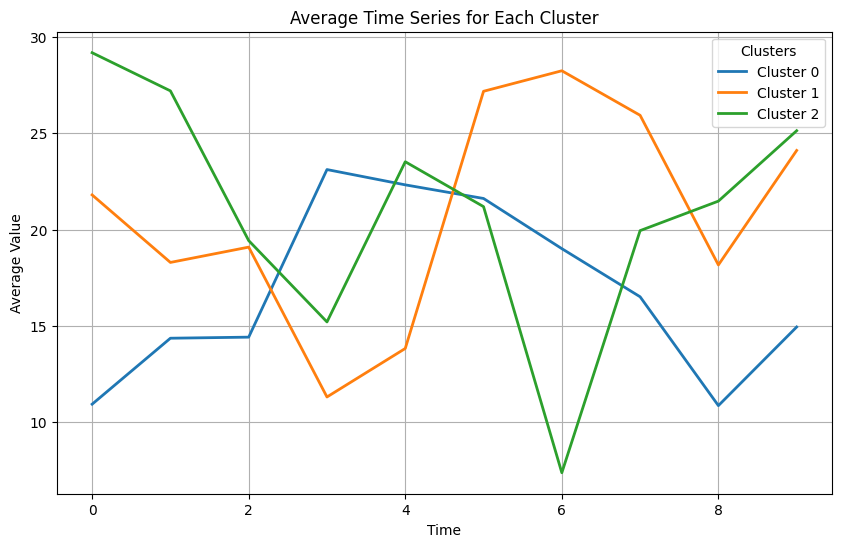

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example DataFrame with columns for 'cluster', 'time', and 'value'
# Suppose each row represents a single data point of a time series associated with a cluster label

# Sample data
data = {
    'cluster': [0, 0, 0, 1, 1, 1, 2, 2, 2] * 10, # Cluster labels
    'time': list(range(10)) * 9, # Time points for each cluster
    'value': np.random.rand(90) * 20 + np.repeat([5, 10, 15], 30)  # Random values for illustration
}
df = pd.DataFrame(data)

# Calculate the average time series for each cluster
# Pivot the DataFrame to have 'time' as index and clusters as columns for aggregation
avg_df = df.pivot_table(index='time', columns='cluster', values='value', aggfunc='mean')

# Plotting
plt.figure(figsize=(10, 6))

for cluster in avg_df.columns:
    plt.plot(avg_df.index, avg_df[cluster], label=f'Cluster {cluster}', linewidth=2)

# Labels and title
plt.xlabel('Time')
plt.ylabel('Average Value')
plt.title('Average Time Series for Each Cluster')
plt.legend(title="Clusters")
plt.grid(True)

# Show plot
plt.show()


In [2]:
df

,cluster,time,value
0,0,0,10.188433
1,0,1,13.172533
2,0,2,6.665225
3,1,3,14.237539
4,1,4,6.866633
...,...,...,...
85,1,5,24.244925
86,1,6,32.278966
87,2,7,15.431896
88,2,8,18.384190


In [3]:
avg_df

cluster,0,1,2
time,,,
0,10.931022,21.801892,29.187846
1,14.357789,18.294498,27.205957
2,14.413158,19.089731,19.428627
3,23.118915,11.305801,15.203924
4,22.324311,13.825282,23.524811
5,21.616419,27.184698,21.193071
6,19.010144,28.250230,7.370956
7,16.510175,25.937604,19.946495
8,10.856796,18.164324,21.479264
